# Computations for vorticity, potential density, buoyancy and PV

In [1]:
import xarray as xr
from xgcm import Grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
ppdir = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/OM4p25_JRA55do1.4_0netfw_cycle6/gfdl.ncrc4-intel16-prod/pp/';
dsgrid = xr.open_dataset(f'{ppdir}/ocean_monthly_z/ocean_monthly_z.static.nc')

In [3]:
ds = xr.open_mfdataset(f'{ppdir}/ocean_monthly_z/ts/monthly/1yr/*.nc', combine='by_coords')

In [4]:
ds = xr.merge([ds, dsgrid])
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'},
                        'Z': {'center': 'z_l', 'outer': 'z_i'} }, periodic=['X']);
print(ds)

<xarray.Dataset>
Dimensions:       (nv: 2, time: 12, xh: 1440, xq: 1440, yh: 1080, yq: 1080, z_i: 36, z_l: 35)
Coordinates:
  * nv            (nv) float64 1.0 2.0
  * time          (time) object 2018-01-16 12:00:00 ... 2018-12-16 12:00:00
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * z_i           (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l           (z_l) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    average_T1    (time) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    average_T2    (time) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    obvf

# Vorticity and potential density

In [5]:
vorticity = ( - grid.diff(ds.uo * ds.dxCu, 'Y', boundary='fill')
              + grid.diff(ds.vo * ds.dyCv, 'X', boundary='fill') ) / ds.areacello_bu;

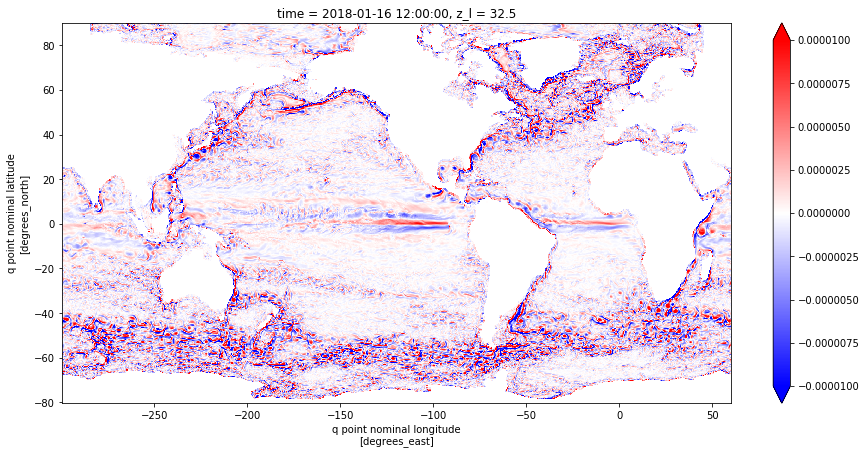

In [23]:
tmp = vorticity.isel({'z_l': slice(3,4), 'time' : slice(0,1)})

fig = plt.figure(figsize=(15,7))
tmp.plot(cmap = 'bwr', vmin = -1e-5, vmax = 1e-5)

In [6]:
# Function to compute potential density
def pdens(S,theta):
    
    # --- Define constants (Table 1 Column 4, Wright 1997, J. Ocean Tech.)---
    a0 = 7.057924e-4
    a1 = 3.480336e-7
    a2 = -1.112733e-7

    b0 = 5.790749e8
    b1 = 3.516535e6
    b2 = -4.002714e4
    b3 = 2.084372e2
    b4 = 5.944068e5
    b5 = -9.643486e3

    c0 = 1.704853e5
    c1 = 7.904722e2
    c2 = -7.984422
    c3 = 5.140652e-2
    c4 = -2.302158e2
    c5 = -3.079464
    
    # To compute potential density keep pressure p = 100 kpa
    # S in standard salinity units psu, theta in DegC, p in pascals
    
    p = 100000.
    alpha0 = a0 + a1*theta + a2*S
    p0 = b0 + b1*theta + b2*theta**2 + b3*theta**3 + b4*S + b5*theta*S
    lambd = c0 + c1*theta + c2*theta**2 + c3*theta**3 + c4*S + c5*theta*S 
    
    pot_dens = (p + p0)/(lambd + alpha0*(p + p0))
    
    return pot_dens    

In [7]:
pot_density = pdens(ds.so, ds.thetao)
print(pot_density)

<xarray.DataArray (time: 12, z_l: 35, yh: 1080, xh: 1440)>
dask.array<truediv, shape=(12, 35, 1080, 1440), dtype=float32, chunksize=(12, 35, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2018-01-16 12:00:00 ... 2018-12-16 12:00:00
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03


In [8]:
den_plt = pot_density.isel({'z_l': slice(0,1), 'time' : slice(0,1)})
den_plt.load()

<xarray.DataArray (time: 1, z_l: 1, yh: 1080, xh: 1440)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * time     (time) object 2018-01-16 12:00:00
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * z_l      (z_l) float64 2.5

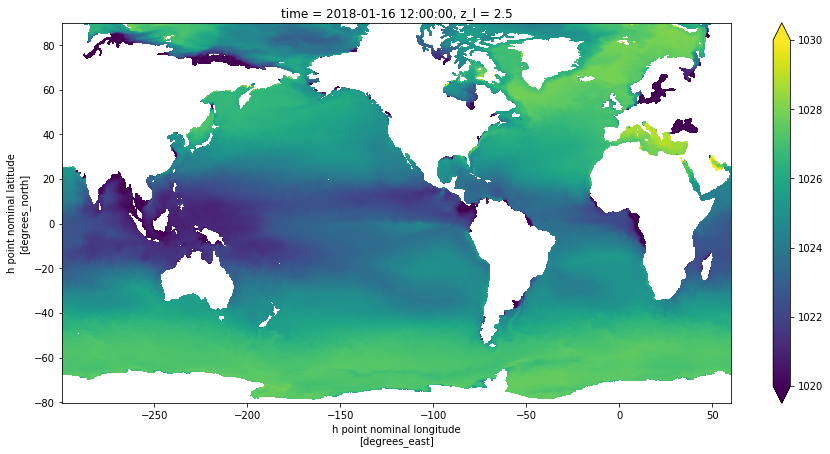

In [9]:
fig = plt.figure(figsize=(15,7))
#fig.add_subplot(2, 1,1)
#vort_plt.plot(cmap='bwr', vmin=-1e-5, vmax=1e-5)
#fig.add_subplot(2, 1,2)
den_plt.plot(vmin = 1020, vmax = 1030)

# Buoayncy and geostrophic shear

In [10]:
# Interpolate Coriolis on different grids
f_xh = grid.interp(ds.Coriolis, 'X', boundary='fill')
f_yh = grid.interp(ds.Coriolis, 'Y', boundary='fill')

# mean vertical density profile (area weighted mean) and density anomalies
dens_z = pot_density.mean('time')
dens_z = (dens_z*ds.areacello).sum(['xh', 'yh'])/(ds.areacello*dens_z/dens_z).sum(['xh','yh'])
anom_density = pot_density - dens_z

dz = grid.diff(ds.z_i, 'Z', boundary='fill')
mean_density = (dens_z*dz).sum('z_l')/dz.sum('z_l')
print(mean_density.load())
g = 9.81

# density gradients in x and y
dens_x = grid.diff(anom_density*ds.dyt, 'X', boundary='fill')/ds.areacello_cu
dens_y = grid.diff(anom_density*ds.dxt, 'Y', boundary='fill')/ds.areacello_cv

# Geostrophic shear
dz_ug = dens_y*g/(f_xh*mean_density)
dz_vg = - dens_x*g/(f_yh*mean_density)

/home/Hemant.Khatri/anaconda3/envs/analysis_python3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/Hemant.Khatri/anaconda3/envs/analysis_python3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray ()>
array(1027.66403696)


/home/Hemant.Khatri/anaconda3/envs/analysis_python3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/Hemant.Khatri/anaconda3/envs/analysis_python3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/Hemant.Khatri/anaconda3/envs/analysis_python3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


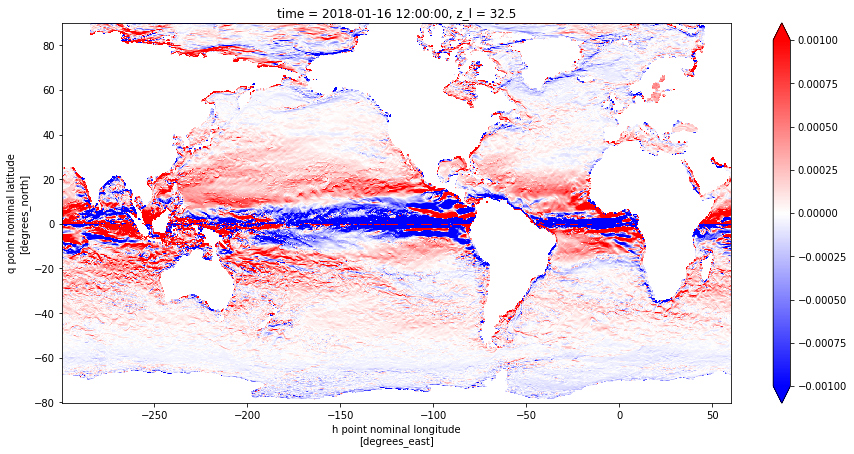

In [12]:
# Geostrophic Shear plot
tmp = dz_ug.isel({'z_l': slice(3,4), 'time' : slice(0,1)})

fig = plt.figure(figsize=(15,7))
tmp.plot(cmap = 'bwr', vmin = -.001, vmax = 0.001)

# PV 

In [36]:
buoyancy = -g*(pot_density - mean_density)/mean_density
buo_zi = grid.interp(buoyancy, 'Z', boundary='fill')

b_z = grid.diff(mean_density*buo_zi/ds.obvfsq, 'Z', boundary='fill')/dz

b_z = grid.interp(b_z, 'X', boundary='fill')
b_z = grid.interp(b_z, 'Y', boundary='fill')

PV = vorticity + ds.Coriolis**2*b_z/mean_density # add ds.Coriolis to compute full PV

print(PV)

<xarray.DataArray (time: 12, z_l: 35, yq: 1080, xq: 1440)>
dask.array<add, shape=(12, 35, 1080, 1440), dtype=float64, chunksize=(12, 33, 1079, 1439), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2018-01-16 12:00:00 ... 2018-12-16 12:00:00
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * yq       (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.68 89.78 89.89 90.0
  * xq       (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16


/home/Hemant.Khatri/anaconda3/envs/analysis_python3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/Hemant.Khatri/anaconda3/envs/analysis_python3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*args2)
/home/Hemant.Khatri/anaconda3/envs/analysis_python3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in add
  return func(*args2)


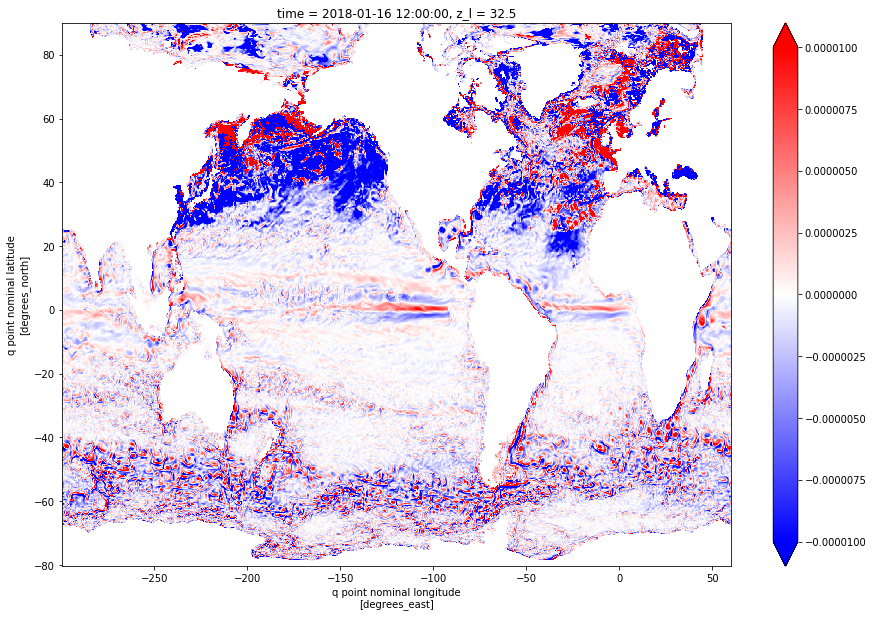

In [38]:
tmp = PV.isel({'z_l': slice(3,4), 'time' : slice(0,1)})
tmp = tmp
fig = plt.figure(figsize=(15,10))
tmp.plot(cmap = 'bwr', vmin = -1e-5, vmax = 1e-5)

# Geostrophic Currents (in progress)

In [16]:
# Geostrophic currents
#ug = grid.cumsum((dz_ug*dz), 'Z', boundary='fill')[::-1]
#dz_ug1 = dz_ug.transpose('z_l', 'time', 'yq', 'xh')
#print(dz_ug1)

ug = grid.cumsum((dz_ug1[::-1]*dz[::-1]), 'Z', boundary='fill')
print(ug)

<xarray.DataArray 'concatenate-d973e759956d127d72f89ac0eb5b9512' (z_i: 36, time: 12, yq: 1080, xh: 1440)>
dask.array<concatenate, shape=(36, 12, 1080, 1440), dtype=float64, chunksize=(35, 12, 1079, 1440), chunktype=numpy.ndarray>
Coordinates:
  * z_i      (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * time     (time) object 2018-01-16 12:00:00 ... 2018-12-16 12:00:00
  * yq       (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.68 89.78 89.89 90.0
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03


In [17]:
ug
tmp = ug.isel({'z_i': slice(0,1), 'time' : slice(0,1)})
tmp.load()

<xarray.DataArray 'concatenate-d973e759956d127d72f89ac0eb5b9512' (z_i: 1, time: 1, yq: 1080, xh: 1440)>
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])
Coordinates:
  * z_i      (z_i) float64 0.0
  * time     (time) object 2018-01-16 12:00:00
  * yq       (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.68 89.78 89.89 90.0
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03

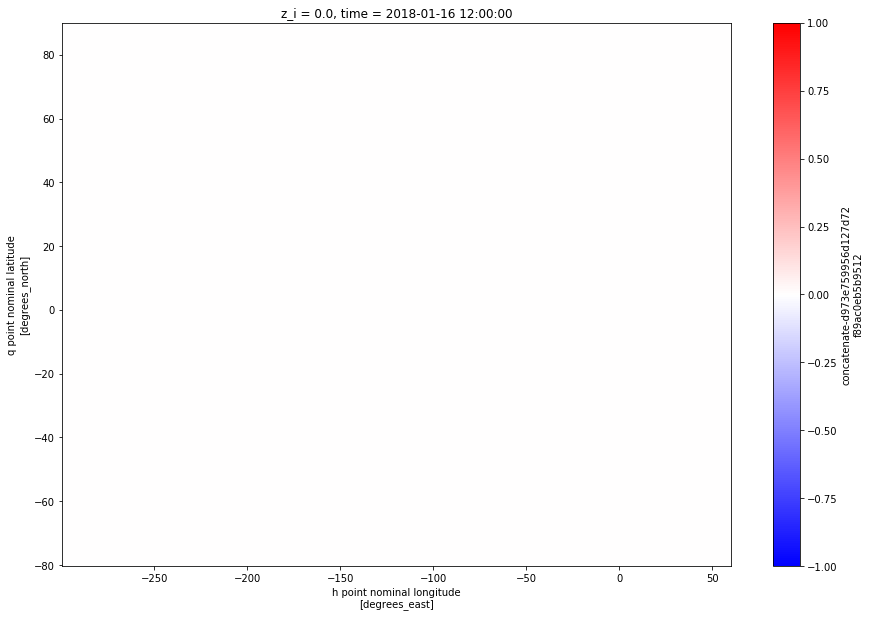

In [18]:
%matplotlib inline
fig = plt.figure(figsize=(15,10))
#fig.add_subplot(2, 1,1)
#vort_plt.plot(cmap='bwr', vmin=-1e-5, vmax=1e-5)
#fig.add_subplot(2, 1,2)
tmp.plot(cmap = 'bwr', vmin = -1, vmax = 1.)